# Data investigation notebook

This notebook explores data praparation for the task.

## Setup

Rename original "Barbora Homework  ML Engineer.xlsx" to "barbora.xlsx". 




In [1]:
import numpy as np 
import pandas as pd 
import seaborn as sns 
import matplotlib.pyplot as plt 
from datetime import datetime, date, time

from prettytable import PrettyTable
from statsmodels.tsa.seasonal import seasonal_decompose

## Data ingestion

In [2]:
df1 = pd.read_excel("barbora.xlsx", parse_dates=['Date'], sheet_name="Revenue")
df1 = df1.set_index('Date')

In [3]:
df1.head()

,Revenue
Date,
2018-01-01,0.00
2018-01-02,0.00
2018-01-03,3087464.68
2018-01-04,2770763.36
2018-01-05,0.00


In [4]:
# combine date and time columns together
df = pd.read_excel('barbora.xlsx', parse_dates=[['dt', 'time']], sheet_name="Weather")
df.rename(columns={'dt_time': "date"}, inplace=True)
df.head()

,date,temperature,dew_point,humidity,wind,wind_speed,pressure,precipitation,condition
0,2018-01-01 00:20:00,0,0,1.0,S,11,982,0,Mist
1,2018-01-01 00:50:00,0,0,1.0,S,14,983,0,Mist
2,2018-01-01 01:20:00,0,0,1.0,S,11,982,0,Mist
3,2018-01-01 01:50:00,0,0,1.0,S,14,982,0,Mostly Cloudy
4,2018-01-01 02:20:00,0,0,1.0,S,14,981,0,Light Rain


In [5]:
df2 = df.copy()

## Data Quality: inspection and cleanup

### Weather dataset

#### Continuous data

In [6]:
df2.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
temperature,86990.0,7.880251,9.178441,-237.00,1.00,7.00,15.00,340.0
dew_point,86990.0,3.722911,7.727982,-25.00,-1.00,3.00,10.00,22.0
humidity,86990.0,0.779709,0.192704,0.15,0.65,0.85,0.93,1.0
wind_speed,86990.0,13.511185,7.444308,0.00,9.00,12.00,19.00,49.0
pressure,86990.0,992.038694,9.052114,952.00,987.00,993.00,998.00,1024.0
precipitation,86990.0,0.000000,0.000000,0.00,0.00,0.00,0.00,0.0


#### Categorical data

In [7]:
def makeDQRCategorical(dataFrame):

 
  return [dataFrame.name,
          dataFrame.size, 
            ((dataFrame.isna().sum() + dataFrame.isnull().sum()) / dataFrame.size) * 100,
          dataFrame.unique().size,
           dataFrame.mode()[0],
           dataFrame.value_counts()[0],
         ((dataFrame.value_counts()[0] / dataFrame.size) * 100).round(3) ,
          dataFrame.value_counts().keys()[1],
           dataFrame.value_counts()[1],
          ((dataFrame.value_counts()[1] / dataFrame.size) * 100).round(3),
          
          ]

In [8]:
categoricalFeatures = PrettyTable(['Feature', 'Count', '% Miss', 'Card.', 'Mode', 'Mode Freq',
                 'Mode %', '2nd Mode', '2nd Mode Freq', '2nd Mode %'])
categoricalFeatures.add_row(makeDQRCategorical((df2['wind'])))
categoricalFeatures.add_row(makeDQRCategorical((df2['condition'])))


print(categoricalFeatures)

+-----------+-------+--------+-------+------+-----------+--------+---------------+---------------+------------+
|  Feature  | Count | % Miss | Card. | Mode | Mode Freq | Mode % |    2nd Mode   | 2nd Mode Freq | 2nd Mode % |
+-----------+-------+--------+-------+------+-----------+--------+---------------+---------------+------------+
|    wind   | 86990 |  0.0   |   18  |  S   |   12894   | 14.822 |       W       |      7355     |   8.455    |
| condition | 86990 |  0.0   |   58  | Fair |   32250   | 37.073 | Mostly Cloudy |     16223     |   18.649   |
+-----------+-------+--------+-------+------+-----------+--------+---------------+---------------+------------+


### Insights

Continuous:

 * investigate temperature (min max too extreme) - keep between -60, +48 ([Europe records](https://en.wikipedia.org/wiki/List_of_weather_records))
 * drop precipitation - constant variable (cardinality 1)

Categortical:
 * modify wind to numeric
 * one-hot encode condition

 For both, interpolate or fill missing dates and variables

### Temperature 

In [9]:
# interpolate errornous inputs 
df2['temperature'][df2[df2.temperature < -60].index] = np.nan
df2['temperature'][df2[df2.temperature > 48].index] = np.nan
df2['temperature'] = df2['temperature'].interpolate()

<ipython-input-9-a461c2cb7b99>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['temperature'][df2[df2.temperature < -60].index] = np.nan


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fb7b5df08b0>]],
      dtype=object)

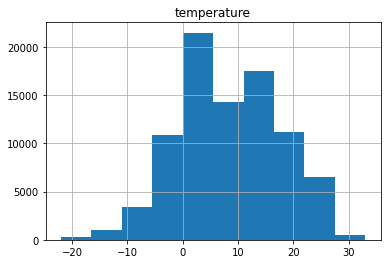

In [10]:
df2.hist(column=['temperature'])

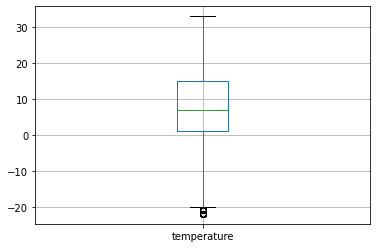

In [11]:
df2.boxplot(column=['temperature'])

### Precipitation

In [12]:
# drop precipitation because it is constant
df2 = df2.drop(columns=['precipitation'])

### Downsampling

In [13]:
# because we need daily predictions, minutes data -> daily (downsampling)

downsampling_type = ({'temperature':'mean',
                      'dew_point':'mean',
                      'humidity':'mean',
                      'wind':'max',
                      'wind_speed':'mean',
                      'pressure':'mean',
                      'condition':'max'})
df2 = df2.resample('D', on='date').agg(downsampling_type)
df2.reset_index(inplace=True)

In [14]:
df2.head()

,date,temperature,dew_point,humidity,wind,wind_speed,pressure,condition
0,2018-01-01,3.240741,3.018519,0.984444,SW,20.555556,979.111111,Wintry Mix
1,2018-01-02,2.333333,2.175439,0.980351,SW,13.543860,985.035088,Mostly Cloudy
2,2018-01-03,1.923077,1.653846,0.973077,SSW,15.461538,979.807692,Partly Cloudy
3,2018-01-04,2.285714,1.428571,0.928571,SSE,24.040816,973.959184,Mostly Cloudy
4,2018-01-05,2.290909,1.618182,0.915818,SSW,23.563636,975.309091,Rain


### Fill missing dates

In [15]:
# make sure all dates exist. Add empty if needed
df2 = df2.set_index('date')

idx = pd.date_range('2018-01-01', '2022-10-28')

df2.index = pd.DatetimeIndex(df2.index)
df2 = df2.reindex(idx, fill_value=0)
df2.reset_index(inplace=True)
df2.rename(columns={'index': "date"}, inplace=True)

### Wind to numeric

In [16]:
# transform categoriacla features into numerical ones
wind_transformation = {'N':0, 'NNE':22.5,"NE":45,"ENE":67.5,
                       'E':90,'ESE':112.5, 'SE':135,'SSE':157.5,
                       'S':180,'SSW':202.5, 'SW':225,'WSW':247.5,
                       'W':270,'WNW':292.5,'NW':315,'NNW':337.5,
                       'N':0,'VAR':0, np.nan:0}

df2['wind'] = df2['wind'].replace(wind_transformation)

In [17]:
df2['wind_speed'] = df2['wind_speed'].fillna(0)

### One-hot encode condition


In [18]:
one_hot = pd.get_dummies(df2['condition'])
df2 = df2.drop('condition',axis = 1)
df2 = df2.join(one_hot)

df2.head()

,date,temperature,dew_point,humidity,wind,wind_speed,pressure,Cloudy,Cloudy / Windy,Fair,...,Snow / Windy,Snow Shower,Snow Shower / Windy,T-Storm,T-Storm / Windy,Thunder,Thunder / Windy,Thunder in the Vicinity,Wintry Mix,Wintry Mix / Windy
0,2018-01-01,3.240741,3.018519,0.984444,225.0,20.555556,979.111111,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,2018-01-02,2.333333,2.175439,0.980351,225.0,13.543860,985.035088,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2018-01-03,1.923077,1.653846,0.973077,202.5,15.461538,979.807692,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2018-01-04,2.285714,1.428571,0.928571,157.5,24.040816,973.959184,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2018-01-05,2.290909,1.618182,0.915818,202.5,23.563636,975.309091,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Investigate missing values

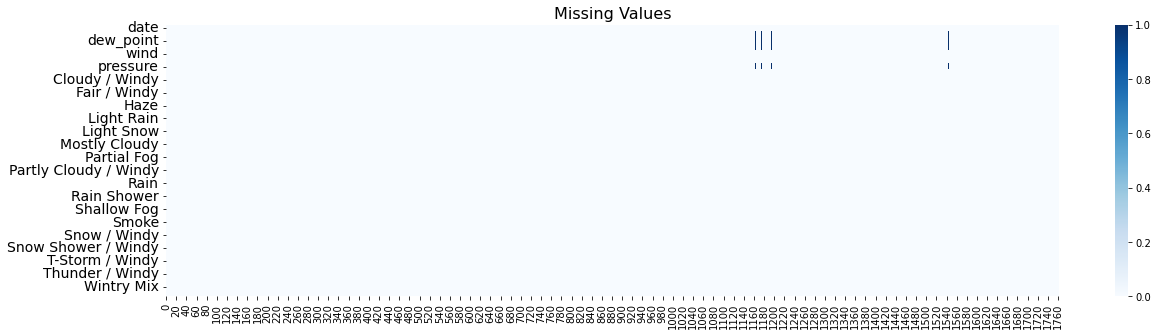

In [19]:
f, ax = plt.subplots(nrows=1, ncols=1, figsize=(20,5))

sns.heatmap(df2.T.isna(), cmap='Blues')
ax.set_title('Missing Values', fontsize=16)

for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(14)
plt.show()

Because most missing values are full random days, linear interpolation will be used to fill them.

In [20]:
# interpolate all except date

for col in df2.columns[1:]:
  df2[col] = df2[col].interpolate()

### Seasonality identification

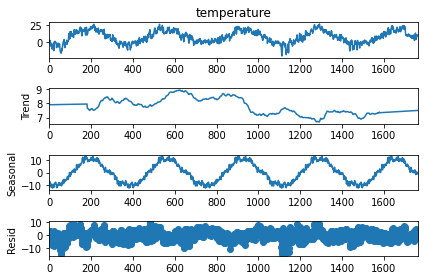

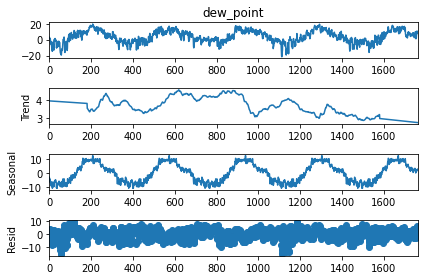

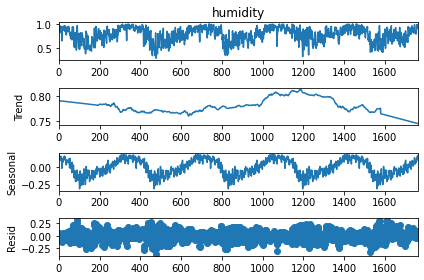

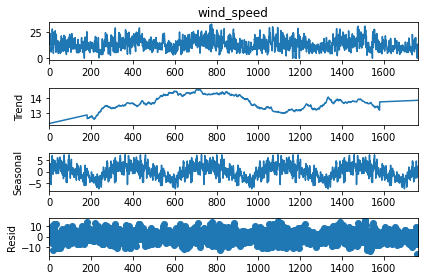

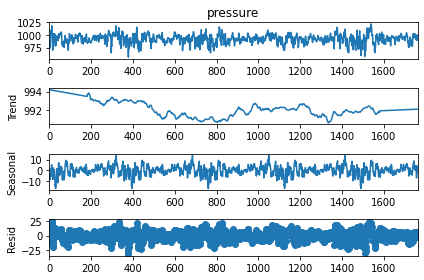

In [21]:
core_columns =  [
    'temperature', 'dew_point', 'humidity', 
    'wind_speed', 'pressure'
]

for column in core_columns:
    decomp = seasonal_decompose(df2[column], model='additive', period=365, extrapolate_trend='freq')
    decomp.plot()


# Add additional columns to dataframe
    df2[f"{column}_trend"] = decomp.trend
    df2[f"{column}_seasonal"] = decomp.seasonal

### Revenue data

In [22]:
# make sure all dates exist. Add empty if needed
idx = pd.date_range('2018-01-01', '2022-10-28')
df1.index = pd.DatetimeIndex(df1.index)
df1 = df1.reindex(idx, fill_value=0)
df1.head()

,Revenue
2018-01-01,0.00
2018-01-02,0.00
2018-01-03,3087464.68
2018-01-04,2770763.36
2018-01-05,0.00


In [23]:
# move date to column
df1.reset_index(inplace=True)
df1.rename(columns={'index': "Date"}, inplace=True)
df1.head()

,Date,Revenue
0,2018-01-01,0.00
1,2018-01-02,0.00
2,2018-01-03,3087464.68
3,2018-01-04,2770763.36
4,2018-01-05,0.00


In [24]:
df1.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Revenue,1762.0,6.329930e+08,2.634470e+10,0.0,3256181.28,5036468.1,7203944.32,1.105855e+12


Maximum value seems to be a significant outlier. Interpolate.

### Add missing values

In [25]:
# Interpolate missing values
df1.replace(0, np.nan, inplace=True)
df1['Revenue'] = df1['Revenue'].interpolate()

# Manually add first 2 values, copy from the first real value
df1['Revenue'][0] = df1['Revenue'][2]
df1['Revenue'][1] = df1['Revenue'][2]

<ipython-input-25-f65ac385461b>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['Revenue'][0] = df1['Revenue'][2]
<ipython-input-25-f65ac385461b>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['Revenue'][1] = df1['Revenue'][2]


### Interpolate max value

In [26]:
# Interpolate maximum value, which is a significant outlier
df1.replace(df1['Revenue'][df1['Revenue'].idxmax()], np.nan, inplace=True)
df1['Revenue'] = df1['Revenue'].interpolate()
df1['Revenue'][df1['Revenue'].idxmax()]

12578072.04

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fb7b3d381c0>]],
      dtype=object)

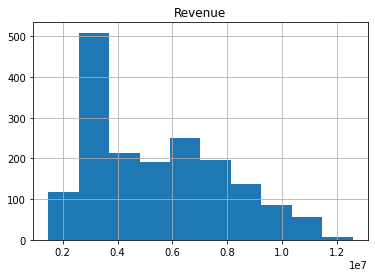

In [27]:
df1.hist(column=['Revenue'])

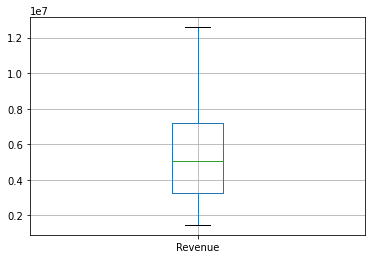

In [28]:
df1.boxplot(column=['Revenue'])

In [29]:
df1.head()

,Date,Revenue
0,2018-01-01,3087464.68
1,2018-01-02,3087464.68
2,2018-01-03,3087464.68
3,2018-01-04,2770763.36
4,2018-01-05,2802336.20


## Export Data

In [30]:
df2.to_csv('data.csv', index=False)
df1.to_csv('revenue.csv', index=False)